In [ ]:
!nvidia-smi

### Install TensorFlow and TensorFlow Model Garden

---



In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.3.0


In [ ]:
!pip install -q tensorflow==2.3.0

In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

## Import required libraries

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

## Loading of the Dataset

In [ ]:
df30 = pd.read_csv("train.En.csv")   

In [ ]:
df30

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3463,3463,The population spike in Chicago in 9 months is...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3464,3464,You'd think in the second to last English clas...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3465,3465,I’m finally surfacing after a holiday to Scotl...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3466,3466,Couldn't be prouder today. Well done to every ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df30= df30[["tweet","sarcasm"]]  # Select tweet and sarcasm category from the dataset 

In [ ]:
df30

,tweet,sarcasm
0,The only thing I got from college is a caffein...,0.0
1,I love it when professors draw a big question ...,1.0
2,Remember the hundred emails from companies whe...,0.0
3,Today my pop-pop told me I was not “forced” to...,1.0
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1.0
...,...,...
3463,The population spike in Chicago in 9 months is...,NaN
3464,You'd think in the second to last English clas...,NaN
3465,I’m finally surfacing after a holiday to Scotl...,NaN
3466,Couldn't be prouder today. Well done to every ...,NaN


In [ ]:
df30 = df30[0:867]  # Take data where there is no none values

In [ ]:
df30

,tweet,sarcasm
0,The only thing I got from college is a caffein...,0.0
1,I love it when professors draw a big question ...,1.0
2,Remember the hundred emails from companies whe...,0.0
3,Today my pop-pop told me I was not “forced” to...,1.0
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1.0
...,...,...
862,yo @claires do yall do hysterectomies?,1.0
863,@JacobWohlReport Do I need to aquire a wife be...,1.0
864,I get a lot of boy who cried wolf vibes from t...,0.0
865,Update: holding hands with your mom and walkin...,1.0


##Data Cleaning

In [ ]:
import re  # Regular Expression
from nltk.corpus import stopwords   # Import stopwords from nltk corpus
import nltk

b = list(df30["tweet"])


wordnet=WordNetLemmatizer()
nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
    review = ' '.join(review)
    corpus.append(review)
df2 = df30.assign(clean_tweet2 = corpus)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df3 = df2[["clean_tweet2","sarcasm"]]
df3.head()

,clean_tweet2,sarcasm
0,thing got college caffeine addiction,0.0
1,love professor draw big question mark next ans...,1.0
2,remember hundred email company covid started g...,0.0
3,today pop-pop told “forced” go college 🙃 okay ...,1.0
4,"too, also reported cancun cruz worrying heartb...",1.0


###Train- test splitting

In [ ]:
train_df, remaining = train_test_split(df3, random_state= 42, train_size= 0.75, stratify=df3.sarcasm.values) # 0.0075 because to divide in into 10k
test_df, valid_df = train_test_split(remaining , random_state= 42, train_size= 0.60, stratify=remaining.sarcasm.values) # three 0.00075 because to divide the data into thousand
train_df.shape, valid_df.shape, test_df.shape

((650, 2), (87, 2), (130, 2))

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['clean_tweet2'].values, train_df['sarcasm'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.clean_tweet2.values, valid_df.sarcasm.values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'oh goodness. it\xe2\x80\x99s first week summer holiday harrison found recorder. give. me. strength.', shape=(), dtype=string)
tf.Tensor(1.0, shape=(), dtype=float64)


## Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the tweet and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0,1] #  Label categories
max_seq_length = 120 # maximum length of (token) input sequences
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable = True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case =bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [ ]:
tokenizer.wordpiece_tokenizer.tokenize("hi, Uday what are doing?")  # test of tokenizer

['hi', '##,', '[UNK]', 'what', 'are', 'doing', '##?']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("hi, Uday what are doing?"))

[7632, 29623, 100, 2054, 2024, 2725, 29632]

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy()) # guid gives unqui id but we are working one example at time so its is  and we use text.numpy because text is in tensor so to get value of it we use np
                                             # and we are doing only sentence classification so be but text_b equal to none but if it is next sentence prediction it would be different
  # Now we have to convert this example into features 
  features = classifier_data_lib.convert_single_example(0, example, label_list,max_seq_length, tokenizer) # 0 is the index of first example

  return (features.input_ids, features.input_mask, features.segment_ids, features.label_id) # below text is important plz read carefully 
  

## Task 7: Wrap a Python Function into a TensorFlow op for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                Tout =[tf.int32,tf.int32,tf.int32,tf.int32]) # Tout is tensor output
  # but here issue is this function wrapper doesn't set shape of return tensor but we don't need the shape of label tensor. So we will set the shape of this tensor
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([]) # because we don't know that shape of label may be in multiclassification it can be more than 2

  x = {
      "input_word_ids" : input_ids,
       "input_mask" : input_mask,
       "input_type_ids" : segment_ids
  }

  return (x, label_id)
  

## Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train              # here tf.data.experimental.AUTONE predict what is the optimal number of call should be and drop_remainder is true as to make any other batch size eequal to 32
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE).shuffle(1000).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))  

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))
  

In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

##  Add a Classification Head to the BERT Layer

In [ ]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1,activation="sigmoid", name="output")  (drop)

  model = tf.keras.Model(
      inputs= {
          "input_word_ids" : input_word_ids,
          "input_mask" : input_mask,
          "input_type_ids" : input_type_ids
      },
      outputs = output)
  return model

##  Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

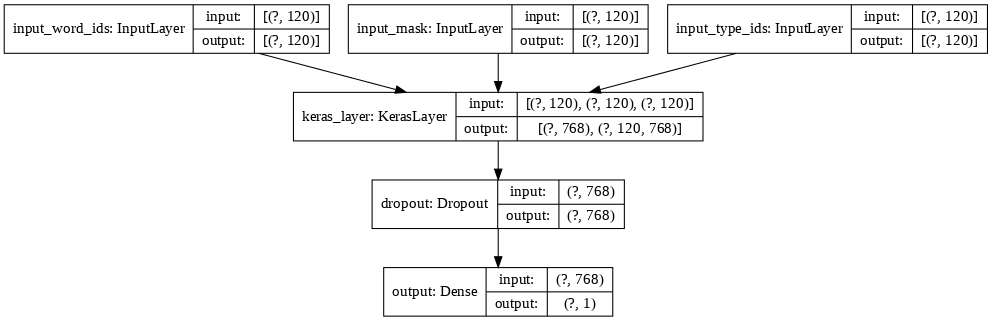

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi = 76) # by default dpi is 96 , result show layer is single layer

In [ ]:
# Train model
epochs = 6 # after 2 this start overfitting
history = model.fit(train_data, validation_data=valid_data, epochs=epochs, verbose=1)

Epoch 1/6
20/20 [==============================] - ETA: 0s - loss: 0.5096 - binary_accuracy: 0.8156WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0093s vs `on_test_batch_end` time: 0.1378s). Check your callbacks.


20/20 [==============================] - 10s 491ms/step - loss: 0.5096 - binary_accuracy: 0.8156 - val_loss: 0.5108 - val_binary_accuracy: 0.7969
Epoch 2/6
20/20 [==============================] - 9s 452ms/step - loss: 0.4654 - binary_accuracy: 0.8266 - val_loss: 0.5104 - val_binary_accuracy: 0.7969
Epoch 3/6
20/20 [==============================] - 9s 452ms/step - loss: 0.4795 - binary_accuracy: 0.8266 - val_loss: 0.5144 - val_binary_accuracy: 0.7969
Epoch 4/6
20/20 [==============================] - 9s 453ms/step - loss: 0.4793 - binary_accuracy: 0.8188 - val_loss: 0.5096 - val_binary_accuracy: 0.7969
Epoch 5/6
20/20 [==============================] - 9s 452ms/step - loss: 0.4068 - binary_accuracy: 0.8234 - val_loss: 0.5293 - val_binary_accuracy: 0.7969
Epoch 6/6
20/20 [==============================] - 9s 452ms/step - loss: 0.2985 - binary_accuracy: 0.8625 - val_loss: 0.5563 - val_binary_accuracy: 0.7812


##  Evaluate the BERT Text Classification Model

In [ ]:
pred_data = pd.read_csv("/content/taskB.En.input.csv")  # Test data for Sem-Eval subtask B
pred_data.head()

,text
0,saw a video of someone getting a hug. would LO...
1,"""This Christmas I hope you all either get vacc..."
2,It's the alamo
3,"Wind 5 mph E. Barometer 1029.8 hPa, Pressure t..."
4,I constantly have loads of the new symptoms bu...


In [ ]:
pred_list2 = pred_data.text.values
pred_list2

array(['saw a video of someone getting a hug. would LOVE a hug. u know those really nice ones',
       '"This Christmas I hope you all either get vaccinated or wear a mask. The omicron variant is not going to give us a nice Christmas gift by deciding to not be spread amongst people." ',
       "It's the alamo", ...,
       'Of course it’s raining when I’m due to go out tonight 👍🏻',
       'Weigh up a lie before you tell it.',
       'Upand dressed at a reasonable time once again now that I have a new bathroom floor down'],
      dtype=object)

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((pred_list2, [0]*len(pred_list2))) 
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.5 # between 0 and 1
prediction2 = [ 1 if pred>threshold else 0 for pred in preds]

In [ ]:
prediction2.count(1)

1241

In [ ]:
len(prediction2)

1400

In [ ]:
f1_score_13556_part2 = pd.DataFrame(prediction2, columns =['Label'])
f1_score_13556_part2

,Label
0,1
1,0
2,1
3,0
4,1
...,...
1395,1
1396,0
1397,0
1398,1


In [ ]:
df5 = f1_score_13556_part2.to_csv("taskb_sarcasm.csv", index = False)

In [ ]:
#########################################################################################

In [ ]:
pred_list = test_df.clean_tweet2.values
pred_list

array(['fun musical mashup country music playing gym one guy playing old eminem phone full volume locker room shower 🎶🎶🎶',
       'quarantine day 256: dear ancient greeks, re: blanket-wearing—i get it. #quarantinelife',
       'social care young basically bath board bed rest done.',
       "'margaret thatcher' trending... 2016 taken another one?",
       'basically thieves, quoting it’s small print can’t refund. date moved summer, 4 hour slot friday evening november much use telescopic sight knife.#wewantarefund',
       'told matthew stafford cooper kupp eat breakfast together drafted robert wood him?',
       'saw matt hancock video i’m scared ten day time climb telly',
       'funny phone start turning piece shit new iphone come 🤔',
       'casual reminder #allbirthdaysmatter can’t stress enough✨fuck trump✨',
       'weather mid life crisis',
       'sometimes feel like effort like sticking diamond encrusted alloy knackered corsa. mean, shit end day.',
       'one find motivation ba

In [ ]:
true_labels = test_df['sarcasm'].tolist()
true_labels

[0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((pred_list, [0]*len(pred_list))) 
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.5  # between 0 and 1
prediction = [ 1 if pred>threshold else 0 for pred in preds]

In [ ]:
prediction.count(1)

123

In [ ]:
len(prediction)

130

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(true_labels, prediction))

              precision    recall  f1-score   support

         0.0       0.29      0.09      0.13        23
         1.0       0.83      0.95      0.89       107

    accuracy                           0.80       130
   macro avg       0.56      0.52      0.51       130
weighted avg       0.73      0.80      0.75       130



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_labels,prediction)

array([[  2,  21],
       [  5, 102]])